## Libraries

In [1]:
import json
import pandas as pd
import os

## Config

In [2]:
# Load the config file
with open('../config/config.json', 'r') as f:
    config = json.load(f)

file_path = config["data_loc"]
file_name = "QTL_text.json"
final_path = os.path.join(file_path, file_name) 

## Import Dataset

In [3]:
# Load json file
df = pd.read_json(final_path)
print(f"Shape of the original dataset: {df.shape}", "\n")

df.head()

Shape of the original dataset: (11278, 5) 



,PMID,Journal,Title,Abstract,Category
0,17179536,J Anim Sci. 2007 Jan;85(1):22-30.,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1
1,17177700,J Anim Breed Genet. 2006 Dec;123(6):414-8.,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0
2,17129674,Vet Parasitol. 2007 Apr 10;145(1-2):2-10. Epub...,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0
3,17121599,Anim Genet. 2006 Dec;37(6):543-53.,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1
4,17057239,Genetics. 2006 Dec;174(4):2119-27. Epub 2006 O...,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0


## Pre-processing and other requirements

In [4]:
# "In this project, you will need to use "Abstract" and "Category", and you can ignore the other fields."
df_processed = df[['Abstract', 'Category']]
print(f"Shape before filtering: {df_processed.shape}", "\n")

# "In this project, you need to ignore papers in Category ‘0’."
df_processed = df_processed[df_processed['Category'] == 1]
print(f"Shape after filtering: {df_processed.shape}", "\n")

df_processed.head()

Shape before filtering: (11278, 2) 

Shape after filtering: (1007, 2) 



,Abstract,Category
0,"In a previous study, QTL for carcass compositi...",1
3,A whole-genome quantitative trait locus (QTL) ...,1
5,A partial genome scan using microsatellite mar...,1
7,BACKGROUND: The rate of pubertal development a...,1
10,"Previously, quantitative trait loci (QTL) for ...",1


### Tokenization of Sentences

In [5]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/gabrielvictorgomesferr
[nltk_data]     eira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gabrielvictorgomes
[nltk_data]     ferreira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Using split
df_processed['abstract_split'] = df_processed['Abstract'].apply(lambda token: [token.lower() for token in token.split() if token not in stop_words])

# Using spacy
df_processed['abstract_spacy'] = df_processed['Abstract'].apply(lambda token: [token.text.lower() for token in nlp_spacy(token) if not token.is_stop])

# Using nltk
df_processed['abstract_nltk'] = df_processed['Abstract'].apply(lambda token: [token.lower() for token in word_tokenize(token) if token not in stop_words])

df_processed.head()

,Abstract,Category,abstract_split,abstract_spacy,abstract_nltk
0,"In a previous study, QTL for carcass compositi...",1,"[in, previous, study,, qtl, carcass, compositi...","[previous, study, ,, qtl, carcass, composition...","[in, previous, study, ,, qtl, carcass, composi..."
3,A whole-genome quantitative trait locus (QTL) ...,1,"[a, whole-genome, quantitative, trait, locus, ...","[-, genome, quantitative, trait, locus, (, qtl...","[a, whole-genome, quantitative, trait, locus, ..."
5,A partial genome scan using microsatellite mar...,1,"[a, partial, genome, scan, using, microsatelli...","[partial, genome, scan, microsatellite, marker...","[a, partial, genome, scan, using, microsatelli..."
7,BACKGROUND: The rate of pubertal development a...,1,"[background:, the, rate, pubertal, development...","[background, :, rate, pubertal, development, w...","[background, :, the, rate, pubertal, developme..."
10,"Previously, quantitative trait loci (QTL) for ...",1,"[previously,, quantitative, trait, loci, (qtl)...","[previously, ,, quantitative, trait, loci, (, ...","[previously, ,, quantitative, trait, loci, (, ..."


## Task 1 - WordCloud Visualization

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Frequency Base

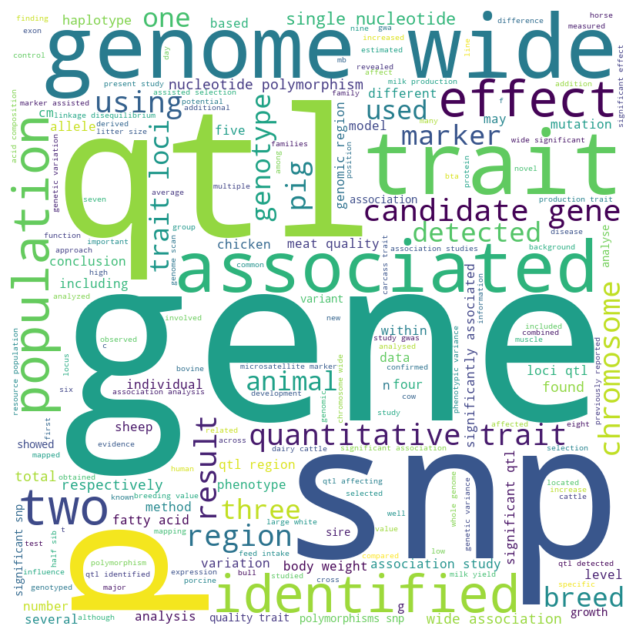

In [8]:
# Define input text
input_text = " ".join([" ".join(words) for words in df_processed['abstract_nltk']])

# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(input_text)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### TD-IDF Base

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

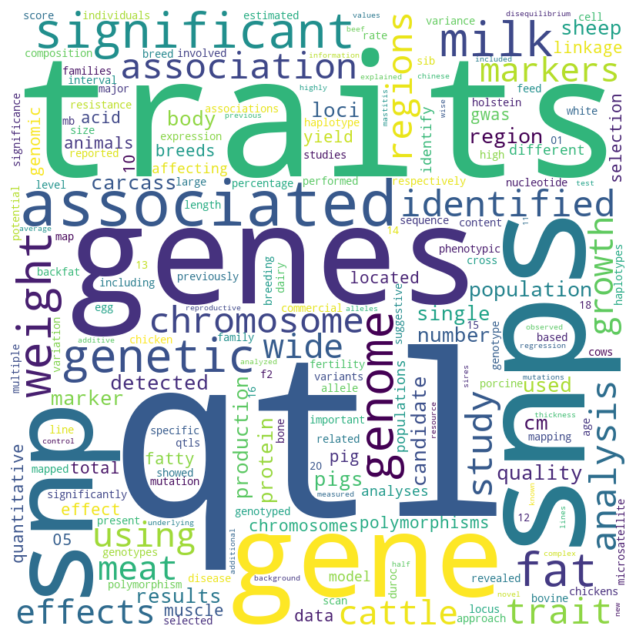

In [10]:
# Compute TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(df_processed['abstract_nltk'].apply(lambda token: " ".join(token)))
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
tfidf_word = dict(zip(tfidf_vec.get_feature_names_out(), tfidf_scores))

# Define word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tfidf_word)

# Display
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
# Top TF-IDF words
top_words_list = []
top_scores_list = []
top_words = sorted(tfidf_word.items(), key=lambda x: x[1], reverse=True)[:10]
for word, score in top_words:
    print(f"{word}: {round(score, 4)}")
    top_words_list.append(word)
    top_scores_list.append(score)

qtl: 0.0621
traits: 0.04
snps: 0.0306
genes: 0.0262
gene: 0.026
snp: 0.0258
associated: 0.0256
significant: 0.0242
milk: 0.0237
genome: 0.0228


## Task 2 - Train a Word2Vec model on this corpus

In [12]:
import gensim
abstract_nltk = df_processed['abstract_nltk']

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(
    vector_size=100,
    window=5,
    min_count=10)

word2vec_model.build_vocab(abstract_nltk)

word2vec_model.train(abstract_nltk, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

(670780, 1016215)

In [13]:

most_similar_dict = {}

for word in top_words:
    similar_words = word2vec_model.wv.most_similar(word[0], topn=20)
    print(f"{word[0]} → {', '.join([w[0] for w in similar_words])}")

    most_similar_dict[word[0]] = [(str(w[0]) + ":" + str(round(w[1], 4))) for w in similar_words]

df_test = pd.DataFrame.from_dict(most_similar_dict, orient='index')
df_test.columns = [f"Similar {i+1}" for i in range(df_test.shape[1])]
df_test.index = range(1, len(df_test) + 1)
df_test.insert(0, "Top Word", top_words_list)
df_test.insert(1, "TF-IDF Score", [round(score, 4) for score in top_scores_list])

df_test

qtl → qtls, mapped, detected, previously, loci, identified, chromosomal, locus, overlapped, reported, one, regions, coincided, interacting, near, trait, harbouring, putative, quantitative, linked
traits → growth, carcass, fatness, eggshell, fertility, bone, production, related, meat, economically, important, egg, quality, performance, measurement, pork, affect, composition, efficiency, reproductive
snps → associations, snp, four, seven, five, intron, single-nucleotide, found, nucleotide, three, six, two, nine, polymorphism, haplotypes, revealed, polymorphisms, single, located, exons
genes → candidate, positional, several, involved, plausible, functional, known, potential, reported, previously, mutations, regions, harboring, promising, chromosomal, gene, responsible, identification, may, related
gene → candidate, positional, coding, genes, plausible, novel, within, promoter, porcine, causal, mutations, bovine, non-synonymous, causative, scd, several, encoding, close, functional, dgat1
s

,Top Word,TF-IDF Score,Similar 1,Similar 2,Similar 3,Similar 4,Similar 5,Similar 6,Similar 7,Similar 8,...,Similar 11,Similar 12,Similar 13,Similar 14,Similar 15,Similar 16,Similar 17,Similar 18,Similar 19,Similar 20
1,qtl,0.0621,qtls:0.9607,mapped:0.9091,detected:0.8642,previously:0.8499,loci:0.8177,identified:0.813,chromosomal:0.8099,locus:0.8063,...,one:0.7867,regions:0.7859,coincided:0.7837,interacting:0.7704,near:0.7651,trait:0.7628,harbouring:0.7611,putative:0.7601,quantitative:0.7563,linked:0.7499
2,traits,0.0400,growth:0.9268,carcass:0.904,fatness:0.8824,eggshell:0.8822,fertility:0.882,bone:0.8646,production:0.8587,related:0.8496,...,important:0.8214,egg:0.8212,quality:0.8146,performance:0.8127,measurement:0.8111,pork:0.8065,affect:0.8046,composition:0.8004,efficiency:0.7917,reproductive:0.789
3,snps,0.0306,associations:0.9283,snp:0.8699,four:0.852,seven:0.852,five:0.8447,intron:0.8257,single-nucleotide:0.8229,found:0.8146,...,six:0.8034,two:0.8007,nine:0.7879,polymorphism:0.7849,haplotypes:0.7838,revealed:0.781,polymorphisms:0.78,single:0.7774,located:0.7685,exons:0.7657
4,genes,0.0262,candidate:0.9682,positional:0.951,several:0.8948,involved:0.8896,plausible:0.8815,functional:0.8757,known:0.8658,potential:0.8652,...,mutations:0.8273,regions:0.8258,harboring:0.8254,promising:0.8143,chromosomal:0.8085,gene:0.8083,responsible:0.8072,identification:0.7922,may:0.7866,related:0.7859
5,gene,0.0260,candidate:0.8474,positional:0.8449,coding:0.8242,genes:0.8083,plausible:0.7987,novel:0.7965,within:0.7896,promoter:0.7888,...,mutations:0.7656,bovine:0.7654,non-synonymous:0.7634,causative:0.7484,scd:0.747,several:0.7413,encoding:0.7403,close:0.7305,functional:0.7291,dgat1:0.7286
6,snp,0.0258,polymorphism:0.9137,snps:0.8699,haplotypes:0.8511,single-nucleotide:0.8458,nucleotide:0.8418,conformational:0.8345,revealed:0.8343,single:0.8309,...,three:0.803,associations:0.8022,k:0.7991,bp:0.7906,sequence:0.7872,seven:0.7865,50:0.7841,two:0.7829,synonymous:0.7788,chip:0.7771
7,associated,0.0256,significantly:0.7988,also:0.7833,found:0.7717,receptor:0.7698,near:0.7631,factor:0.7514,bta14:0.7468,scd:0.7327,...,linked:0.7163,well-known:0.7082,insulin-like:0.7065,encoding:0.7037,several:0.7027,qtls:0.7003,transcription:0.6977,dgat1:0.6916,highly:0.6907,igf1:0.6854
8,significant,0.0242,suggestive:0.9117,found:0.8898,associations:0.8817,significance:0.8735,level:0.8707,detected:0.8588,chromosome-wide:0.8536,genome-wise:0.8408,...,showed:0.8282,nominal:0.8252,exceeded:0.8051,reached:0.8051,no:0.8042,revealed:0.8038,highly:0.8,haplotype:0.7876,four:0.7843,respectively:0.7646
9,milk,0.0237,chl:0.9409,summer:0.8918,fatty:0.8747,acids:0.8615,yield:0.8539,composition:0.8539,deposition:0.8463,acid:0.8329,...,fa:0.8194,production:0.812,intramuscular:0.81,content:0.8085,somatic:0.8073,yields:0.788,cell:0.7775,metabolism:0.7747,saturated:0.7731,contents:0.7723
10,genome,0.0228,mapping:0.9591,scan:0.9587,map:0.929,approach:0.92,conducted:0.9021,whole:0.8984,performed:0.8977,whole-genome:0.8868,...,previous:0.8602,we:0.8569,studies:0.8535,wide:0.8514,applied:0.8475,analyses:0.8424,regression:0.8397,fine:0.8385,detect:0.8365,gwa:0.8345
